In [1]:
import sys
import numpy as np
from numpy import genfromtxt
import tkinter as tk
from tkinter import filedialog
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy import stats
from ipfx import feature_extractor
from ipfx import subthresh_features as subt
from ipfx import feature_vectors as fv
from ipfx.sweep import Sweep
from sklearn.preprocessing import minmax_scale
from pyAPisolation.loadABF import loadABF
import sklearn.preprocessing
import pyabf
import logging
import glob
from brian2 import *
method='trf'

INFO       Cache size for target "cython": 2936 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\SMest\.cython\brian_extensions" directory. [brian2]


In [16]:

def exp_grow(t, a, b, alpha):
    return a - b * np.exp(-alpha * t)

def exp_grow_2p(t, a, b1, alphaFast, b2, alphaSlow):
    return a - b1 * np.exp(-alphaFast * t) - b2*np.exp(-alphaSlow*t) 

def exp_grow_clampfit(t, a, b1, alphaFast, b2, alphaSlow):
    return b1 * np.exp((-t)/alphaFast) + b2*np.exp((-t)/alphaSlow) + a

def exp_grow1_clampfit(t, a, b1, alphaFast):
    return b1 * np.exp((-t)/alphaFast) + a

In [18]:
def exp_growth_factor(dataT,dataV,dataI, end_index=300):
    #try:
        
        diff_I = np.diff(dataI)
        upwardinfl = np.argmax(diff_I)

        #Compute out -50 ms from threshold
        dt = dataT[1] - dataT[0]
        offset = 0.01/ dt 

        end_index = int(end_index - offset)


        
        upperC = np.amax(dataV[upwardinfl:end_index])
        lowerC  = np.amin(dataV[upwardinfl:end_index])
        diffC = np.abs(lowerC - upperC)
        t1 = dataT[upwardinfl:end_index] - dataT[upwardinfl]
        curve = curve_fit(exp_grow, t1, dataV[upwardinfl:end_index], maxfev=50000, bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))[0]
        curve2 = curve_fit(exp_grow_clampfit, t1, dataV[upwardinfl:end_index], bounds=([lowerC*1.5, -np.inf, 1e-3,-np.inf, -1e3], [lowerC*0.95, np.inf, np.inf, np.inf, np.inf]), maxfev=50000000, xtol=None, gtol=None, ftol=1e-12)[0]
        tau = curve[2]
        tau1 = 1/curve2[2]
        tau2 = 1/curve2[4]
        tau_idx = [2, 4]
        fast = tau_idx[np.argmin([tau1, tau2])]
        slow = tau_idx[np.argmax([tau1, tau2])]
        
        curve_out = [curve2[0], curve2[fast-1], curve2[fast], curve2[slow-1], curve2[slow]]


        #plt.subplot(1,2,1)
        plt.plot(t1, dataV[upwardinfl:end_index], c='k', alpha=0.5)
        plt.plot(t1, exp_grow_clampfit(t1, *curve2), label=f'2 phase fit', c='r', alpha=0.5)
        plt.plot(t1, exp_grow1_clampfit(t1, *curve_out[:3]), label=f'Fast phase', c='g', alpha=0.5)
        plt.plot(t1, exp_grow1_clampfit(t1, curve_out[0], *curve_out[3:]), label=f'slow phase', c='b', alpha=0.5)
        plt.title(f" CELL will tau1 {1/curve2[fast]} and tau2 {1/curve2[slow]}")
        #plt.subplot(1,2,2)
        plt.legend()
        #plt.twinx()
        #plt.subplot(1,2,2)
        dy = curve_detrend(t1, dataV[upwardinfl:end_index], curve2)
         #signal.savgol_filter(nt1p.diff(dataV[upwardinfl:end_index])/np.diff(t1), 71, 2, mode='mirror')
        #plt.plot(t1,dy)
        
        curve_out = [curve2[0], curve2[fast-1], 1/curve2[fast], curve2[slow-1], 1/curve2[slow]]
        return curve_out, np.amax(dy)
    #except:
        return [np.nan, np.nan, np.nan, np.nan, np.nan]

In [19]:
files = glob.glob('C:\\Users\\SMest\\Documents\\clustering-data\\\All IC1s\\*.abf', recursive=True)

In [20]:
cell_type_df = pd.read_csv("C:\\Users\\SMest\\Documents\\clustering-data\\MARM_PVN_IC1\\spike_count_sort_out.csv")
print(cell_type_df.head)
file_names = cell_type_df['filename'].to_numpy()
cell_type_label = cell_type_df['cell_label'].to_numpy()

<bound method NDFrame.head of             filename  label  cell_label  CRH_label  Sag Ratio 001  \
0    2020_01_16_0003      2          -1         -1       0.072335   
1    2020_01_16_0011      1           1         -1       0.053301   
2    2020_01_16_0020      2           3         -1       0.183200   
3    2020_01_16_0025      2          -1         -1       0.200844   
4    2020_01_16_0029      0          -1          0       0.044166   
..               ...    ...         ...        ...            ...   
152         21311038      1           0         -1       0.065753   
153         21311047      1           1         -1       0.069595   
154         21311063      5           1         -1       0.291042   
155         21311074      1          -1         -1       0.123829   
156         21311084      1           1         -1       0.290186   

     Sag Ratio 002  Sag Ratio 003  Sag Ratio 004  Sag Ratio 005  \
0         0.480277       1.081981       1.528664       1.856069   
1      

In [21]:
curves = []
label = []
ids = []
max_curve = []
for i, f in enumerate(files[:]):
    print(i)
    try:
        base = os.path.basename(f)
        base = base.split(".")[0]
        if base in file_names:
            x, y, c = loadABF(f)
            
            temp_curves =[]
            #plt.clf()
            iterd = 0
            for sweepX, sweepY, sweepC in zip(x,y,c):
                spikext = feature_extractor.SpikeFeatureExtractor(filter=0, end=1.25)
                res = spikext.process(sweepX, sweepY, sweepC)
                if res.empty==False and iterd < 3:
                    iterd += 1
                    spike_time = res['threshold_index'].to_numpy()[0]
                    #plt.figure(num=2)
                    curve, max_dy = exp_growth_factor(sweepX, sweepY, sweepC, spike_time)
                    max_curve.append(max_dy)
                    temp_curves.append(curve)
            temp_curves = np.vstack(temp_curves)
            div = np.ravel((temp_curves[:,2]) / (temp_curves[:,4])).reshape(-1,1)
            
            sum_height= (temp_curves[:,1] + temp_curves[:,3])
            ratio = (temp_curves[:,2] / (temp_curves[:,1] / sum_height)) / (temp_curves[:,4] / (temp_curves[:,3] / sum_height))
            ratio = np.ravel(ratio).reshape(-1,1)
            temp_curves = np.hstack([temp_curves, div, ratio])
            print(temp_curves)
            meanC = np.nanmean(temp_curves, axis=0)
            print(meanC.shape)
            curves.append(meanC)
            label_idx = np.argwhere(file_names==base)
            

            label.append(cell_type_label[label_idx])
            
            ids.append(base)
            plt.savefig(f+".png")
            #plt.show()
            
            plt.close()
    except:
        print("fail")
curves = np.vstack(curves)

0
1
[[-108.3069   53.9949   -3.1805 ...  156.0823   -0.0204    0.006 ]
 [-106.5216   50.0759   -8.6345 ...  267.047    -0.0323    0.0086]
 [-107.2083   46.2189  -18.9862 ...  464.3098   -0.0409    0.0085]]
(7,)
2
[[-116.6046   46.9145   -3.6725 ...   31.3936   -0.117     0.1308]
 [-117.4164   53.3899   -5.8678 ...   36.9204   -0.1589    0.1761]
 [-120.2866  110.7372    0.     ...   26.0923    0.       -0.    ]]
(7,)
3
[[ -87.0621   19.0436   -5.2077 ...   36.6004   -0.1423    0.1746]
 [-139.9384   67.4094   -4.2809 ...   46.9742   -0.0911    0.0273]
 [-139.5264   61.8617   -8.0044 ...   86.334    -0.0927    0.0225]]
(7,)
4
[[-141.4032  109.0447    0.2217 ...   12.4424    0.0178   -0.0097]
 [ -90.2222   53.2879    0.     ...   18.0223    0.       -0.    ]
 [-143.7836  150.2485    1.9958 ...   15.2724    0.1307   -0.0872]]
(7,)
5
6
[[ -114.4409 14866.087      6.4596 ...     6.5226     0.9903    -0.9876]
 [ -115.2649 14580.3299     9.9897 ...    10.0933     0.9897    -0.987 ]
 [ -115.1276

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[  -73.0301    34.9454     0.     ...    40.7177     0.        -0.    ]
 [  -73.0301    63.4793     6.1117 ...    33.2466     0.1838    -0.1928]
 [ -114.4867 11967.1137    16.5786 ...    16.8094     0.9863    -0.9831]]
(7,)
11
[[ -73.32     25.3845   -7.5947 ...   48.0994   -0.1579    0.1814]
 [-112.4057   88.3352   -0.001  ...   35.8035   -0.        0.    ]
 [-107.2083   46.9718  -18.1018 ...  146.1113   -0.1239    0.0297]]
(7,)
12
13
[[-69.725   24.0291  -4.3491 ...  81.971   -0.0531   0.0625]
 [-69.4351  68.3677  11.6795 ...  45.8074   0.255   -0.2683]
 [-67.0288  36.4733  -0.001  ...  78.573   -0.       0.    ]]
(7,)
14
[[-72.8851  32.9757   0.     ...  36.4917   0.      -0.    ]
 [-72.1024  35.1275   0.     ...  48.4169   0.      -0.    ]
 [-71.9574  36.4402   0.     ...  59.9905   0.      -0.    ]]
(7,)
15
[[-72.7322  30.3161   0.     ...  43.2868   0.      -0.    ]
 [-69.2322  28.2612   0.     ...  58.035    0.      -0.    ]
 [-67.9855  21.2402  -4.9123 ... 153.3938  -0.032    

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[ -64.9414 3237.2688   89.3305 ...   89.9018    0.9936   -0.9943]
 [ -64.6515 2000.6073  198.8878 ...  200.4634    0.9921   -0.9935]
 [ -66.275     2.346  -259.3428 ... 1000.       -0.2593    0.5673]]
(7,)
23
[[-71.9864  32.6855   0.     ...  31.5218   0.      -0.    ]
 [-72.5952  34.2075   0.     ...  44.7841   0.      -0.    ]
 [-72.9721  30.2319  -2.9127 ...  66.4352  -0.0438   0.0485]]
(7,)
24
[[-106.7963   66.54     -0.8294 ...  118.1504   -0.007     0.0029]]
(7,)
25


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: divide by zero encountered in double_scalars
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: invalid value encountered in multiply
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value encountered in double_scalars
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta

[[-67.3187  16.0754  -7.2052 ...  69.4038  -0.1038   0.1239]
 [-68.4494  36.2066   0.     ...  40.7018   0.      -0.    ]
 [-66.478   41.404   -0.001  ...  44.1557  -0.       0.    ]]
(7,)
26
[[ -70.6238   29.2993    0.     ...   40.1865    0.       -0.    ]
 [-112.0605   72.3469   -0.5744 ...   50.5934   -0.0114    0.0053]
 [-112.793   105.3154    3.8819 ...   36.4666    0.1065   -0.067 ]]
(7,)
27
[[-73.2483  32.4752   0.     ...  43.4428   0.      -0.    ]
 [-71.6965  31.2179   0.     ...  67.9001   0.      -0.    ]
 [-71.6965  24.4304  -4.4113 ... 163.0447  -0.0271   0.0322]]
(7,)
28


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: divide by zero encountered in double_scalars
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: invalid value encountered in multiply
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value encountered in double_scalars
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta

[[-74.1318  34.3281   0.     ...  35.7152   0.      -0.    ]
 [-73.7839  29.0142  -3.0998 ...  65.7137  -0.0472   0.0543]
 [-73.291   43.6851   2.9301 ...  57.6244   0.0508  -0.0556]]
(7,)
29
[[ -78.4515   37.8895    0.     ...   21.3912    0.       -0.    ]
 [ -78.3936   23.1397   -8.2407 ...   42.7637   -0.1927    0.2237]
 [-123.1384   64.1162   -6.7543 ...   52.0271   -0.1298    0.0451]]
(7,)
30
[[-74.0158  22.744   -2.9797 ...  54.9127  -0.0543   0.0637]
 [-73.8708  26.8128  -3.0963 ...  53.3934  -0.058    0.0651]
 [-74.1898  34.5291  -1.0394 ...  49.2352  -0.0211   0.0229]]
(7,)
31
[[-72.7402  21.6577  -0.8797 ... 113.3452  -0.0078   0.0096]
 [-72.0444  28.7648   0.     ...  64.7309   0.      -0.    ]
 [-73.5519  26.0513  -1.1261 ... 134.1892  -0.0084   0.0103]]
(7,)
32
[[-80.336   31.7037  -0.4424 ...  41.6928  -0.0106   0.0128]
 [-80.365   40.5797   0.     ...  38.0468   0.      -0.    ]
 [-80.7709  43.0583   0.     ...  47.4164   0.      -0.    ]]
(7,)
33
34
35
[[-92.9474  16.6

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio 

[[-95.9915  34.2112  -0.4368 ...  40.1214  -0.0109   0.0133]
 [-96.6003  43.9144   0.     ...  37.0106   0.      -0.    ]
 [-95.3537  43.6852   0.     ...  58.4735   0.      -0.    ]]
(7,)
42
[[-91.0919  20.6595 -12.8972 ...  49.6199  -0.2599   0.3193]
 [-93.0344  25.51   -15.9267 ...  57.7137  -0.276    0.3274]
 [-95.8991  79.5658   0.     ...  30.5242   0.      -0.    ]]
(7,)
43
[[ -89.7583   18.7427   -6.5156 ...   42.8629   -0.152     0.1866]
 [ -91.7297   20.8699   -8.6538 ...   51.0169   -0.1696    0.2039]
 [-146.759    69.9982   -6.0836 ...   77.605    -0.0784    0.0231]]
(7,)
44
[[ -80.0171   26.4226   -4.5871 ...   42.5754   -0.1077    0.125 ]
 [ -80.8578   36.0983   -4.7267 ...   37.4337   -0.1263    0.1401]
 [-127.533    74.9575   -5.4994 ...   51.8536   -0.1061    0.0456]]
(7,)
45
46
47


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-87.178   39.7498   0.     ...  21.3891   0.      -0.    ]
 [-86.3953  42.298    0.     ...  33.1657   0.      -0.    ]
 [-86.8591  67.7892   4.0725 ...  30.2936   0.1344  -0.142 ]]
(7,)
48


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-77.2049  38.5618   0.     ...  14.9103   0.      -0.    ]
 [-76.857   44.3072   0.     ...  24.5274   0.      -0.    ]
 [-76.712   47.268   -0.001  ...  31.6777  -0.       0.    ]]
(7,)
49
[[-86.7722  42.8274   0.     ...  20.235    0.      -0.    ]
 [-85.3226  42.78    -1.2682 ...  32.9856  -0.0384   0.0426]
 [-86.5692  69.7424   2.7821 ...  29.2417   0.0951  -0.1012]]
(7,)
50


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-85.1196  33.7067  -0.4143 ...  43.7253  -0.0095   0.0112]
 [-83.844   40.4869   0.     ...  40.4417   0.      -0.    ]
 [-83.0322  41.0415   0.     ...  58.916    0.      -0.    ]]
(7,)
51
[[-100.4272   36.2413   -2.0124 ...   20.41     -0.0986    0.112 ]
 [-102.9205   44.0676   -2.4684 ...   19.7709   -0.1248    0.1375]
 [-106.6025   85.9089   -0.001  ...   15.1802   -0.0001    0.0001]]
(7,)
52
[[-97.2382  57.8419   0.     ...  42.0984   0.      -0.    ]
 [-99.7604 163.9503   8.1397 ...  24.1642   0.3369  -0.351 ]
 [-97.0932 321.3592  14.3306 ...  24.4349   0.5865  -0.5994]]
(7,)
53
[[ -81.3797   47.1322    0.     ...   22.0783    0.       -0.    ]
 [-130.188    86.3568   -1.7583 ...   34.2651   -0.0513    0.025 ]
 [-130.9662   84.63     -3.4776 ...   42.1767   -0.0825    0.0391]]
(7,)
54
55
56
[[-122.316    41.7084   -1.6874 ...   19.7156   -0.0856    0.0997]
 [-126.6647   48.7616   -4.1763 ...   21.0103   -0.1988    0.2244]
 [-198.6237  116.1454   -3.9906 ...   28.9852   -0.1377 

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-86.1053  48.0656   0.     ...  38.4929   0.      -0.    ]
 [-86.4822  54.0201   1.0583 ...  50.138    0.0211  -0.0235]
 [-84.8587  86.0375   7.8797 ...  44.9436   0.1753  -0.1872]]
(7,)
59


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-70.8847  25.8249  -2.836  ...  96.0764  -0.0295   0.0358]
 [-71.4935  32.2188   0.     ...  76.6445   0.      -0.    ]
 [-72.0734  33.143    0.     ...  89.4971   0.      -0.    ]]
(7,)
60
[[-77.3788  39.4943   0.     ...  28.5968   0.      -0.    ]
 [-78.1036  21.6255 -13.2267 ...  57.5627  -0.2298   0.273 ]
 [-78.3936  58.6702   0.0001 ...  32.3043   0.      -0.    ]]
(7,)
61
[[-82.9742  46.0364   0.     ...  15.0427   0.      -0.    ]
 [-82.1335  23.8098  -8.0976 ...  39.3356  -0.2059   0.2407]
 [-81.7566  27.2162 -10.0189 ...  43.4486  -0.2306   0.263 ]]
(7,)
62
63
[[ -78.8864   35.5116    0.     ...   24.6103    0.       -0.    ]
 [ -79.6112   43.9762    0.     ...   27.1503    0.       -0.    ]
 [-124.9695   87.8266   -1.5923 ...   33.4899   -0.0475    0.0248]]
(7,)
64
[[ -88.3377   40.1241   -0.6193 ...   64.489    -0.0096    0.0116]
 [-139.6637   93.265    -0.264  ...   72.1949   -0.0037    0.002 ]
 [-140.4419   94.4464   -0.2918 ...   83.1035   -0.0035    0.0019]]
(7,)
65
[

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: divide by zero encountered in double_scalars
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: invalid value encountered in multiply
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value encountered in double_scalars
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta

[[-82.9742  45.6811   0.     ...  17.5595   0.      -0.    ]
 [-84.2209  24.186   -7.7887 ...  48.5208  -0.1605   0.1879]
 [-85.6995  23.807  -11.0129 ...  59.5737  -0.1849   0.2174]]
(7,)
68
69


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-83.5541  40.1049   0.     ...  20.1871   0.      -0.    ]
 [-82.9742  40.2709   0.     ...  29.2836   0.      -0.    ]
 [-83.1192  44.9278   0.2263 ...  37.118    0.0061  -0.0068]]
(7,)
70
[[-84.5398  39.7841   0.     ...  14.0096   0.      -0.    ]
 [-84.4818  22.8003  -7.2041 ...  34.1419  -0.211    0.2482]
 [-84.5108  23.0578 -11.4166 ...  40.396   -0.2826   0.332 ]]
(7,)
71
72
73
74
75
76
[[-86.9461  22.3777  -1.5546 ...  18.7725  -0.0828   0.0995]
 [-88.8596  21.4065  -3.9868 ...  23.5628  -0.1692   0.2033]
 [-87.1201  20.878   -7.0117 ...  30.6431  -0.2288   0.2752]]
(7,)
77
[[ -89.1785   11.314    -3.1581 ...   32.4041   -0.0975    0.1316]
 [ -88.2507   13.3407   -8.5949 ...   45.3233   -0.1896    0.25  ]
 [-149.0936   63.5524   -4.9709 ...   83.0433   -0.0599    0.0124]]
(7,)
78


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-93.3243  27.908   -2.8559 ...  20.2044  -0.1414   0.1646]
 [-94.194   25.9418  -6.4965 ...  29.5455  -0.2199   0.2595]
 [-93.0923  31.2303  -7.9179 ...  29.8417  -0.2653   0.3041]]
(7,)
79
[[-164.8865   81.7738   -2.2707 ...   29.3022   -0.0775    0.0245]
 [-162.5519   82.8906   -3.6891 ...   38.4588   -0.0959    0.0324]
 [-164.8865   99.3895   -3.9621 ...   27.9576   -0.1417    0.0614]]
(7,)
80
[[-100.4852   43.6496    0.     ...    5.9362    0.       -0.    ]
 [-102.7466   22.5771   -5.4791 ...   21.7537   -0.2519    0.3076]
 [-101.297    24.4388   -8.3783 ...   25.9095   -0.3234    0.3869]]
(7,)
81
[[-92.7444  45.9261  -1.8411 ...  24.5127  -0.0751   0.0836]
 [-94.339   64.2956  -0.001  ...  25.7383  -0.       0.    ]
 [-93.4982  75.8357   1.7214 ...  28.4986   0.0604  -0.0654]]
(7,)
82
fail
83
[[ -96.6583   55.2903    0.     ...   11.5567    0.       -0.    ]
 [-102.6306   26.898    -7.8242 ...   34.0149   -0.23      0.2687]
 [-102.6886   29.0245  -11.2458 ...   38.7978   -0.289

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[ -93.3533   48.2102    0.     ...   11.627     0.       -0.    ]
 [-153.7628   71.1744   -4.0936 ...   64.9902   -0.063     0.017 ]
 [-153.1677   71.5724   -5.7017 ...   74.6993   -0.0763    0.021 ]]
(7,)
86
87
[[ -92.8314   53.1424    0.     ...   10.5221    0.       -0.    ]
 [-146.9421   66.0846   -4.1781 ...   59.0914   -0.0707    0.0172]
 [-103.9657   27.8933  -11.1082 ...   72.398    -0.1534    0.107 ]]
(7,)
88
[[-84.2209  14.1625  -5.0543 ...  22.8601  -0.2211   0.2806]
 [-80.7129  50.4916   0.     ...   9.2351   0.      -0.    ]
 [-82.9742  14.6338 -11.2771 ...  38.5332  -0.2927   0.3629]]
(7,)
89
[[-108.5739   27.4792   -3.4169 ...   22.0901   -0.1547    0.1833]
 [-180.9082   89.3206   -2.752  ...   26.0927   -0.1055    0.0312]
 [-181.6406   87.4301   -4.3728 ...   38.218    -0.1144    0.0314]]
(7,)
90
[[-100.9201   51.6945    0.     ...   27.898     0.       -0.    ]
 [-101.152    52.5517    0.     ...   42.5995    0.       -0.    ]
 [-100.5432   53.3852    0.     ...   53.

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[  -79.9301    48.2722     0.     ...    20.3331     0.        -0.    ]
 [  -81.2637 10333.0925    14.2221 ...    14.3531     0.9909    -0.9911]
 [  -75.4683 17254.3692     0.0001 ...     0.1134     0.0006    -0.0006]]
(7,)
92
[[-119.6777   57.7212    0.     ...   10.9323    0.       -0.    ]
 [-182.5104   88.0273   -3.3756 ...   39.3189   -0.0859    0.0248]
 [-124.1425   96.4463    0.     ...   15.6712    0.       -0.    ]]
(7,)
93
[[-91.5848  26.5273  -5.7055 ...  34.8298  -0.1638   0.1907]
 [-94.194   44.1618  -4.2772 ...  29.1704  -0.1466   0.1598]
 [-95.6731  83.2725  -0.001  ...  22.7268  -0.       0.    ]]
(7,)
94


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-92.8604  49.2852   0.     ...  24.3934   0.      -0.    ]
 [-93.8751  51.9055   0.     ...  29.1605   0.      -0.    ]
 [-94.223   53.4955   0.     ...  35.719    0.      -0.    ]]
(7,)
95


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[  -73.1461    22.0887     0.     ...    41.4796     0.        -0.    ]
 [  -71.3486 13810.1344    22.5598 ...    22.6484     0.9961    -0.9962]
 [ -113.4338    47.0425   -13.3379 ...   236.4577    -0.0564     0.0095]]
(7,)
96
[[ -81.2637 8565.2456    7.2786 ...    7.3477    0.9906   -0.9908]
 [ -80.8868 8952.0854   12.279  ...   12.393     0.9908   -0.991 ]
 [-126.3428   52.6098  -10.4513 ...  154.3653   -0.0677    0.0113]]
(7,)
97
[[-87.468   37.7601   0.     ...  16.5609   0.      -0.    ]
 [-89.4684  52.9777   0.     ...  17.3928   0.      -0.    ]
 [-86.9171  61.7158   0.     ...  19.0685   0.      -0.    ]]
(7,)
98
99
[[ -81.8726 8900.4767   11.9245 ...   12.0405    0.9904   -0.9906]
 [-128.5858   58.1628   -8.4914 ...   97.5778   -0.087     0.0209]
 [ -81.0318 5482.3359   20.4895 ...   20.8438    0.983    -0.9835]]
(7,)
100


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: divide by zero encountered in double_scalars
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: invalid value encountered in multiply
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value encountered in double_scalars
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta

[[-79.8431  38.8773   0.     ...  23.8444   0.      -0.    ]
 [-80.0461  43.5106   0.     ...  28.6498   0.      -0.    ]
 [-76.683   50.8213   1.7842 ...  31.9751   0.0558  -0.0589]]
(7,)
101
[[ -78.3356   36.7976    0.     ...   32.1194    0.       -0.    ]
 [-124.5575   69.0358   -4.3321 ...   66.4728   -0.0652    0.0243]
 [-117.9657   57.2946  -11.5405 ...  125.6974   -0.0918    0.0263]]
(7,)
102
103
[[ -74.7696   19.3798   -4.3591 ...   51.2514   -0.0851    0.099 ]
 [ -74.4797 9687.6194   14.9451 ...   15.0888    0.9905   -0.9907]
 [ -73.5229   46.0002    0.     ...   37.5257    0.       -0.    ]]
(7,)
104
fail
105
[[ -76.3062   34.9506    0.     ...   24.5246    0.       -0.    ]
 [-118.3777   55.6298   -6.241  ...   71.78     -0.0869    0.0236]
 [-118.0115   55.2162   -8.558  ...   85.5632   -0.1       0.0266]]
(7,)
106
[[-84.7717  42.4964   0.     ...  21.4224   0.      -0.    ]
 [-83.5251  47.1195   0.     ...  28.1243   0.      -0.    ]
 [-83.67    64.9194   2.4431 ...  28.77

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio 

[[-90.1352  47.0116   0.     ...  35.2012   0.      -0.    ]
 [-91.3239  48.5485   0.     ...  46.7689   0.      -0.    ]
 [-92.1356  51.2563   0.     ...  54.1493   0.      -0.    ]]
(7,)
108
[[ -97.847    31.0085   -5.6773 ...   30.9597   -0.1834    0.206 ]
 [ -97.9919   32.3933   -9.6695 ...   39.0114   -0.2479    0.2771]
 [-154.6326   80.6161   -8.1637 ...   56.8831   -0.1435    0.049 ]]
(7,)
109
110
[[-110.7788   55.5354   -3.1374 ...   73.4349   -0.0427    0.0128]
 [-110.4126   50.614    -8.3921 ...  128.5325   -0.0653    0.0156]
 [-110.8246   48.8788  -13.2539 ...  189.8615   -0.0698    0.0147]]
(7,)
111
[[-81.5536  11.275   -4.0821 ...  29.7037  -0.1374   0.196 ]
 [-81.2637  56.1458   0.     ...   8.0534   0.      -0.    ]
 [-81.9016  58.2207   0.     ...  11.5517   0.      -0.    ]]
(7,)
112
113
[[ -65.8691 9343.0319   58.1192 ...   58.4062    0.9951   -0.9954]]
(7,)
114
[[ -96.7743   17.9386   -1.7035 ...   19.2704   -0.0884    0.1121]
 [ -97.934    61.792     0.     ...    8

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[ -91.4688   42.1648    0.     ...   27.3938    0.       -0.    ]
 [-115.0888   72.4484    0.     ...   32.2995    0.       -0.    ]
 [ -92.9474   22.9973  -18.8747 ...   70.393    -0.2681    0.3188]]
(7,)
116
fail
117
[[ -79.3793   40.6174    0.     ...   16.9569    0.       -0.    ]
 [ -79.4952   42.487     0.     ...   27.2571    0.       -0.    ]
 [-125.1526   70.8394   -3.9636 ...   51.5854   -0.0768    0.0312]]
(7,)
118
[[ -77.4078   29.9647    0.     ...   16.374     0.       -0.    ]
 [ -77.3788   34.9797    0.     ...   23.8229    0.       -0.    ]
 [-122.5891   52.7827   -8.9853 ...  106.4336   -0.0844    0.0177]]
(7,)
119


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-89.8453  28.6825   0.     ...  23.2818   0.      -0.    ]
 [-88.4247  32.4929   0.     ...  23.3094   0.      -0.    ]
 [-88.5117  37.2076   1.5252 ...  34.3564   0.0444  -0.05  ]]
(7,)
120
[[  -67.3767 16208.2596     4.1675 ...     4.1826     0.9964    -0.9963]
 [  -91.5753    30.2618    -6.6383 ...   114.2811    -0.0581     0.0165]
 [ -106.2012    44.2527    -7.2676 ...   165.5553    -0.0439     0.008 ]]
(7,)
121
[[  -82.7423    36.4677     0.     ...    30.9844     0.        -0.    ]
 [  -82.0175    49.3243     2.1334 ...    35.9972     0.0593    -0.0634]
 [ -128.0365 24622.6626    16.6619 ...    16.7873     0.9925    -0.9908]]
(7,)
122
[[-103.5004   58.6773    0.     ...   19.3349    0.       -0.    ]
 [ -95.2377   56.1628    0.3834 ...   37.9706    0.0101   -0.011 ]
 [-100.3983   61.066     0.2112 ...   44.1236    0.0048   -0.0052]]
(7,)
123
[[-85.9894  34.623    0.     ...  15.0688   0.      -0.    ]
 [-85.4385  18.1708 -11.8119 ...  45.8362  -0.2577   0.3037]
 [-85.0906  58.9

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-72.6532  34.5863   0.     ...  70.1665   0.      -0.    ]
 [-72.7692  36.3813   0.     ...  68.9446   0.      -0.    ]
 [-72.9141  38.9576   0.     ...  70.2867   0.      -0.    ]]
(7,)
140
141
[[ -78.9444   43.0215    0.     ...   30.7597    0.       -0.    ]
 [-125.1068   93.1664   -0.3971 ...   37.4642   -0.0106    0.0058]
 [-125.1526   73.2536   -6.8127 ...   69.9554   -0.0974    0.0415]]
(7,)
142
[[ -75.3204   39.9534    0.     ...   31.091     0.       -0.    ]
 [ -74.7986   46.1521   -0.001  ...   36.0861   -0.        0.    ]
 [-119.4305   81.0203   -3.3819 ...   50.7786   -0.0666    0.0329]]
(7,)
143
144
145
[[ -89.2654   40.4169    0.     ...   10.9976    0.       -0.    ]
 [ -89.9612   53.5556    0.     ...   13.9756    0.       -0.    ]
 [-140.9912   65.2191   -5.743  ...   67.0613   -0.0856    0.0232]]
(7,)
146


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


fail
147


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[ -76.0162   27.431    -2.4533 ...   24.3918   -0.1006    0.1093]
 [-119.1559   62.7482   -3.7642 ...   42.6127   -0.0883    0.0307]
 [-120.5292   59.3424   -6.2265 ...   65.4205   -0.0952    0.0297]]
(7,)
148
[[-105.7327   30.227    -7.162  ...   36.6544   -0.1954    0.2334]
 [-103.3844   33.1183  -10.381  ...   41.0062   -0.2532    0.2948]
 [ -99.4125   34.0039  -14.6111 ...   47.6328   -0.3067    0.3537]]
(7,)
149
[[-124.9252   40.9864   -4.7448 ...   24.7668   -0.1916    0.2223]
 [-130.8395   51.148    -6.1591 ...   26.6562   -0.2311    0.2628]
 [-195.7855  109.8594   -5.8943 ...   37.17     -0.1586    0.064 ]]
(7,)
150
[[ -99.6445   31.535    -5.5952 ...   33.7465   -0.1658    0.1925]
 [-158.3862   87.4798   -4.4159 ...   39.0878   -0.113     0.044 ]
 [-155.7312   84.3856   -6.3627 ...   50.3016   -0.1265    0.0478]]
(7,)
151
fail
152


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: divide by zero encountered in double_scalars
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: invalid value encountered in multiply
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value encountered in double_scalars
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta

[[ -76.5961   13.2127   -9.8453 ...   55.3414   -0.1779    0.2301]
 [ -77.002    14.5087  -15.1127 ...   63.3368   -0.2386    0.2962]
 [-116.5924   50.2134  -10.3218 ...  123.112    -0.0838    0.0183]]
(7,)
153
[[ -78.1036   32.5493    0.     ...   17.7306    0.       -0.    ]
 [ -76.3062   39.7267    0.     ...   21.0212    0.       -0.    ]
 [-123.642    60.5927   -6.0938 ...   61.0576   -0.0998    0.0312]]
(7,)
154
[[ -81.2057   40.0823    0.     ...   21.2785    0.       -0.    ]
 [-129.1351   60.5162   -6.1468 ...   72.5756   -0.0847    0.0235]
 [-129.1809   63.8685   -7.5246 ...   72.0875   -0.1044    0.0331]]
(7,)
155
[[ -81.8146   42.6798    0.     ...   22.1735    0.       -0.    ]
 [ -82.1045   55.8147   -0.001  ...   24.5924   -0.        0.    ]
 [-129.5471   86.0559   -3.8471 ...   37.5311   -0.1025    0.0507]]
(7,)
156
157
158
159
160


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[ -78.7994   25.7904   -4.3733 ...   46.7361   -0.0936    0.1082]
 [ -77.6978   38.4348    0.     ...   35.362     0.       -0.    ]
 [-126.8463  133.8574    4.3691 ...   30.0468    0.1454   -0.0989]]
(7,)
161
[[ -87.439    48.3515    0.     ...   23.8246    0.       -0.    ]
 [-137.2833   97.9206   -1.7134 ...   32.0516   -0.0535    0.0283]
 [ -86.1643   77.9896   -0.001  ...   27.7965   -0.        0.    ]]
(7,)
162
fail
163


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-87.7869  26.8064  -0.8818 ...  21.3497  -0.0413   0.0515]
 [-86.8881  40.6171   0.     ...  12.5026   0.      -0.    ]
 [-88.1927  43.6169   0.     ...  15.1462   0.      -0.    ]]
(7,)
164
fail
165
[[ -81.4667   22.9859   -7.3224 ...   41.7834   -0.1752    0.2065]
 [ -82.0175   30.8519   -7.1397 ...   39.4722   -0.1809    0.2044]
 [-128.0365   72.4327   -6.2429 ...   50.8183   -0.1228    0.0498]]
(7,)
166


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-80.8578  40.4134   0.     ...  28.6593   0.      -0.    ]
 [-79.7272  42.1189   0.     ...  38.3879   0.      -0.    ]
 [-80.6259  47.9526   0.7714 ...  42.9121   0.018   -0.0197]]
(7,)
167
[[-76.3351  24.7072  -2.0994 ...  53.0262  -0.0396   0.0473]
 [-77.3499  37.0763   0.     ...  34.5329   0.      -0.    ]
 [-77.6688  29.5069  -3.1259 ...  69.2381  -0.0451   0.0536]]
(7,)
168
[[ -72.1603   22.0011   -4.4053 ...   48.191    -0.0914    0.1044]
 [ -71.6675   39.5528    0.     ...   33.7172    0.       -0.    ]
 [-113.7085   59.3622   -7.2113 ...   80.1893   -0.0899    0.0315]]
(7,)
169
170
[[-74.7696  33.0099   0.     ...  39.0027   0.      -0.    ]
 [-75.4654  35.9083   0.     ...  49.7878   0.      -0.    ]
 [-77.1469  40.3571   0.     ...  51.6725   0.      -0.    ]]
(7,)
171
[[-91.1789  52.4498   0.     ...  22.3377   0.      -0.    ]
 [-91.5558  44.5431  -1.6543 ...  42.9492  -0.0385   0.0441]
 [-91.3818  53.9535   0.     ...  42.5642   0.      -0.    ]]
(7,)
172
[[-75.1755  3

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[ -84.3079   41.8427    0.     ...   24.8981    0.       -0.    ]
 [ -83.3221   40.1659    0.     ...   41.3814    0.       -0.    ]
 [-131.9275   60.2456   -9.415  ...  108.5218   -0.0868    0.0223]]
(7,)
174
[[ -98.3688   42.7624   -0.7326 ...   74.3579   -0.0099    0.0124]
 [-100.6882   45.0528   -0.899  ...   91.801    -0.0098    0.0125]
 [ -96.5714   41.7798   -1.0637 ...  122.0949   -0.0087    0.0113]]
(7,)
175
[[-72.4503  32.9921  -1.2123 ...  48.4915  -0.025    0.0273]
 [-72.8851  41.7719  -0.001  ...  49.2972  -0.       0.    ]
 [-72.3923  47.5043  -0.001  ...  51.0785  -0.       0.    ]]
(7,)
176


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-73.7839  25.8951  -3.2282 ...  96.5033  -0.0335   0.0374]
 [-73.233   30.8793  -1.7682 ...  95.2854  -0.0186   0.0202]
 [-74.0738  45.2137   6.5469 ...  80.1241   0.0817  -0.0865]]
(7,)
177
[[ -74.4507   25.1316   -2.4708 ...   52.5297   -0.047     0.0556]
 [ -73.465    39.8222    0.     ...   37.3824    0.       -0.    ]
 [-116.1804   72.8836   -3.398  ...   55.3296   -0.0614    0.0283]]
(7,)
178
[[-140.0299   61.5517  -26.6727 ...  204.1225   -0.1307    0.0317]
 [-137.9242   58.3586  -33.697  ...  272.7667   -0.1235    0.0265]
 [-140.2121  112.278     0.     ...   78.8476    0.       -0.    ]]
(7,)
179
180
181
[[ -97.4991   28.8197   -4.285  ...   32.0769   -0.1336    0.1493]
 [ -98.5428   27.477    -7.863  ...   43.8227   -0.1794    0.2035]
 [-156.3263   78.9223   -5.6456 ...   63.0155   -0.0896    0.0285]]
(7,)
182
183
[[-76.2192  38.5005   0.     ...  35.6902   0.      -0.    ]
 [-73.7259  32.6558  -2.9524 ...  62.7363  -0.0471   0.0525]
 [-76.5671  45.4259   1.0817 ...  60.345

C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-92.5705  19.8397  -5.2211 ...  41.6844  -0.1253   0.1586]
 [-92.5705  22.0069  -9.5644 ...  45.3521  -0.2109   0.2563]
 [-93.3533  22.4861 -14.0353 ...  53.8427  -0.2607   0.3157]]
(7,)


In [22]:
#lab = sklearn.preprocessing.LabelEncoder()
#int_lab = lab.fit_transform(label)
print(curves)
label = np.ravel(label).reshape(-1,1)
div = np.ravel((curves[:,2]) / (curves[:,4])).reshape(-1,1)
print(div)
sum_height= (curves[:,1] + curves[:,3])
ratio = (curves[:,2] / (curves[:,1]/sum_height)) / (curves[:,4] / (curves[:,3]/sum_height))
ratio = np.ravel(ratio).reshape(-1,1)
curves_out = np.hstack([curves, div, ratio, label])
np.savetxt('curves.csv', curves_out, fmt='%.8f', delimiter=',')
np.savetxt('curves_id.csv', ids, fmt='%s', delimiter=',')
print(curves)

[[-107.3456   50.0966  -10.2671 ...  295.813    -0.0312    0.0077]
 [-118.1025   70.3472   -3.1801 ...   31.4688   -0.092     0.1023]
 [-122.1756   49.4382   -5.831  ...   56.6362   -0.1087    0.0748]
 ...
 [ -75.0209   35.0754   -4.9606 ...   57.1106   -0.0635    0.075 ]
 [-123.1496   90.5956   -1.1184 ...   26.908    -0.0307    0.0112]
 [ -92.8314   21.4442   -9.6069 ...   46.9597   -0.1989    0.2435]]
[[-0.0347]
 [-0.1011]
 [-0.103 ]
 ...
 [-0.0869]
 [-0.0416]
 [-0.2046]]
[[-107.3456   50.0966  -10.2671 ...  295.813    -0.0312    0.0077]
 [-118.1025   70.3472   -3.1801 ...   31.4688   -0.092     0.1023]
 [-122.1756   49.4382   -5.831  ...   56.6362   -0.1087    0.0748]
 ...
 [ -75.0209   35.0754   -4.9606 ...   57.1106   -0.0635    0.075 ]
 [-123.1496   90.5956   -1.1184 ...   26.908    -0.0307    0.0112]
 [ -92.8314   21.4442   -9.6069 ...   46.9597   -0.1989    0.2435]]


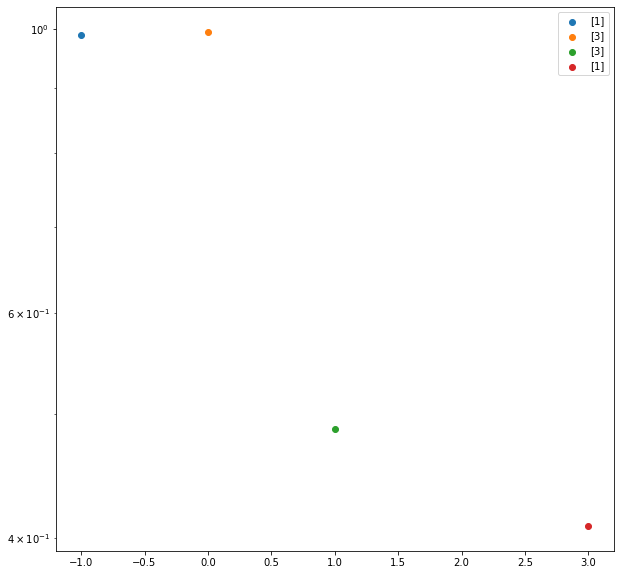

In [23]:
means = []
plt.figure(figsize=(10,10))
plt.clf()
for x in np.unique(label).astype(np.int32):
    idx = np.argwhere(label[:,0]==x).astype(np.int32)
    mcur = curves[idx]
    plt.scatter(np.full(len(idx),  x),  (curves[idx,2]) / (curves[idx,4]), label=label[x])
    means.append(np.nanmean((curves[idx,2]) / (curves[idx,4])))
plt.legend()
plt.yscale('log')
#plt.ylim(0,1)

In [24]:
print(means)

[-0.06708712023506712, 0.045268900319265046, -0.042354042040307106, -0.06682031030654273]


In [25]:
1=1
curves = []
label = []
ids = []
for i, f in enumerate(files[:38]):
    print(i)
    x, y, c = loadABF(f)
    d_name = os.path.dirname(f)
    base = os.path.basename(f)
    ids.append(base)
    label.append(d_name)
    dfs = []
    temp_curves
    plt.clf()
    for sweepX, sweepY, sweepC in zip(x,y,c):
        spikext = feature_extractor.SpikeFeatureExtractor(filter=0)
        res = spikext.process(sweepX, sweepY, sweepC)
        dfs.append(res)
        if res.empty==False:
            if len(non_empty_df) > 1:
                sweep_to_use = non_empty_df[1]
            else:
                sweep_to_use = non_empty_df[-1]
    non_empty_df = np.nonzero(np.invert([df.empty for df in dfs]))[0]
    
    
    try:
        spike_time = dfs[sweep_to_use]['threshold_index'].to_numpy()[0]
        curve = exp_growth_factor(x[sweep_to_use,:], y[sweep_to_use,:], c[sweep_to_use,:], spike_time)
        curves.append(curve)
    except:
        curves.append([np.nan, np.nan, np.nan, np.nan, np.nan])
    plt.show()
print(non_empty_df)

SyntaxError: can't assign to literal (<ipython-input-25-b07f0ea16760>, line 1)